# ECE 4194 Final Project. Spring 2019. The Ohio State University
## Authors: Michael Wharton.124, Alex Whitman.97, Benji Justice.251

This notebook is to train a resnet model to classify the actions specified in the dataset linked below.

Dataset: http://archive.ics.uci.edu/ml/datasets/Smartphone-Based+Recognition+of+Human+Activities+and+Postural+Transitions



### Define packages to autoreload

In [26]:
%load_ext autoreload
%autoreload 1

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
%aimport models.resnet
%aimport utils.data_helpers

### Import necessary modules

In [28]:
# torch modules
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

# import model
from models.resnet import resnet18, resnet34

# data functions
from utils.data_helpers import load_data
from utils.data_helpers import har_dataset

# classics
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import time

### Define model hyper parameters

In [4]:
# what percentage of data should be used for training 
split = 0.7

num_epoch = 3000
lr = 0.5e-7
batch_size = 10
num_workers = 1

### Handle GPU

In [5]:
use_gpu=True
if torch.cuda.is_available() and use_gpu:
    dtype = torch.cuda.FloatTensor
    ltype = torch.cuda.LongTensor
    
    device = torch.device('cuda:0')
    
else:
    dtype = torch.FloatTensor
    ltype = torch.LongTensor
    device = torch.device('cpu')
    
print('device {} dtype {}'.format(device, dtype))

device cuda:0 dtype <class 'torch.cuda.FloatTensor'>


### Load data

In [22]:
# ...
train_data, train_labels, test_data, test_labels = load_data()


In [23]:
# convert to torch Tensor objects
train_data = torch.Tensor(train_data)
train_labels = torch.Tensor(train_labels)

test_data = torch.Tensor(test_data)
test_labels = torch.Tensor(test_labels)

In [8]:
print(train_data.shape)
print(test_data.shape)

print(train_labels.shape)
print(test_labels.shape)

torch.Size([873, 2048, 6])
torch.Size([341, 2048, 6])
torch.Size([873])
torch.Size([341])


In [24]:
best_acc_list = []

drop_prob_list = [0.1] #, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.0]
num_tests = len(drop_prob_list)

results = np.zeros(shape=(num_tests, num_epoch, 2, 2))

### Train !

In [25]:
continue_ = True # if training same more for more epochs
opt.lr=1e-7
for test_num, drop_prob in enumerate(drop_prob_list):
    print('\ndrop prob {}'.format(drop_prob))
  
    # create model

#     model = resnet18(drop_prob=drop_prob)
#     model = model.to(device)

#     # Handle loss function and optimizer
#     crit = torch.nn.CrossEntropyLoss()
#     opt  = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=0)

    # used to track the loss and accuracy over each epoch
    stats = np.zeros(shape=(num_epoch, 2, 2))


        
    # indices
    train = 0
    test  = 1
    acc   = 0
    loss  = 1

    # handle training and testing dataloaders
    train_ds = har_dataset(train_data, train_labels)
    train_dl = DataLoader(train_ds, batch_size=batch_size, num_workers=num_workers,shuffle=True)
    train_batches = train_dl.__len__()

    test_ds = har_dataset(test_data, test_labels)
    test_dl = DataLoader(test_ds, batch_size=batch_size, num_workers=num_workers)
    test_batches = test_dl.__len__()

    best_acc = 0
    tstart = time.time()
    for epoch in range(num_epoch):

        # switch to train mode
        model.train()

        # track accuracy
        total = 0
        correct = 0

        # track loss
        tr_loss = []
        for batch, data in enumerate(train_dl):
            print('Training Iteration: {0:4d} of {1:4d}'.format(batch+1, train_batches), end='\r')

            # extract signal and labels
            signals, labels = data

            ## Normalize?

            # transpose signals (batch_size, length, channels) -> (batch_size, channels, length)
            signals = signals.transpose(1,2)

            # move data to device
            signals = signals.to(device)
            labels = labels.type(ltype).to(device)

            # process signals
            out = model(signals)

            # hard decision for classification
            _, pred = torch.max(out.data, 1)

            # compute accuracy
            total   += labels.size(0)
            correct += (pred == labels).sum().item()

            # compute loss
            b_loss = crit(out, labels)
            opt.zero_grad()
            b_loss.backward()
            opt.step()

            tr_loss.append(b_loss.item())

        # epoch training stats
        tr_accuracy = 100. * correct / total
        tr_loss = np.mean(tr_loss)

        # evaluate model
        model.eval()

        ts_loss = []
        total   = 0
        correct = 0
        with torch.no_grad():
            for batch, data in enumerate(test_dl):
                print('Testing  Iteration:: {0:4d} or {1:4d}'.format(batch+1, test_batches), end='\r')

                # extract signals and labels
                signals, labels = data

                # transpose signals (batch_size, length, channels) -> (batch_size, channels, length)
                signals = signals.transpose(1,2)

                # move data to device
                signals = signals.to(device)
                labels = labels.type(ltype).to(device)

                # process signals
                out = model(signals)

                # hard decision for classification
                _, pred = torch.max(out.data, 1)

                # compute accuracy
                total   += labels.size(0)
                correct += (pred == labels).sum().item()

                # compute loss
                b_loss = crit(out, labels)

                ts_loss.append(b_loss.item())
    
        # epoch testing stats
        ts_accuracy = 100. * correct / total
        ts_loss = np.mean(ts_loss)

        string=''
        if ts_accuracy > best_acc:
            best_acc = ts_accuracy
            string = 'save!'
            
        # save stats to plot later
        stats[epoch, train, loss ] = tr_loss
        stats[epoch, train, acc  ] = tr_accuracy
        stats[epoch, test,  loss ] = ts_loss
        stats[epoch, test,  acc  ] = ts_accuracy

        t1 = time.time() - tstart
        print('Epoch: {0:4d} Tr loss: {1:.3f} Ts loss: {2:.3f} Tr Accuracy: {3:3.2f}% Ts Accuracy: {4:3.2f}% Time: {5:4.2f}s p={6:0.2f} {7:s}'.format(
                epoch+1,      tr_loss,         ts_loss,         tr_accuracy,           ts_accuracy, t1, drop_prob, string))
    
    # save results of each model to plot
    results[test_num,:,:,:] = stats
    best_acc_list.append(best_acc)
    
np.savez('dropout_test',res=results)


drop prob 0.1
Epoch:    1 Tr loss: 0.240 Ts loss: 0.268 Tr Accuracy: 90.03% Ts Accuracy: 89.44% Time: 1.75s p=0.10 save!
Epoch:    2 Tr loss: 0.268 Ts loss: 0.269 Tr Accuracy: 90.49% Ts Accuracy: 88.86% Time: 3.42s p=0.10 
Epoch:    3 Tr loss: 0.256 Ts loss: 0.276 Tr Accuracy: 90.84% Ts Accuracy: 89.15% Time: 5.06s p=0.10 
Epoch:    4 Tr loss: 0.236 Ts loss: 0.306 Tr Accuracy: 91.75% Ts Accuracy: 87.98% Time: 6.72s p=0.10 
Epoch:    5 Tr loss: 0.264 Ts loss: 0.291 Tr Accuracy: 90.26% Ts Accuracy: 87.39% Time: 8.39s p=0.10 
Epoch:    6 Tr loss: 0.236 Ts loss: 0.298 Tr Accuracy: 91.64% Ts Accuracy: 87.39% Time: 10.05s p=0.10 
Epoch:    7 Tr loss: 0.281 Ts loss: 0.264 Tr Accuracy: 91.52% Ts Accuracy: 90.03% Time: 11.69s p=0.10 save!
Epoch:    8 Tr loss: 0.259 Ts loss: 0.268 Tr Accuracy: 89.58% Ts Accuracy: 90.03% Time: 13.52s p=0.10 
Epoch:    9 Tr loss: 0.253 Ts loss: 0.295 Tr Accuracy: 90.84% Ts Accuracy: 86.80% Time: 15.34s p=0.10 
Epoch:   10 Tr loss: 0.250 Ts loss: 0.279 Tr Accuracy

Epoch:   80 Tr loss: 0.273 Ts loss: 0.269 Tr Accuracy: 89.58% Ts Accuracy: 90.03% Time: 132.84s p=0.10 
Epoch:   81 Tr loss: 0.247 Ts loss: 0.283 Tr Accuracy: 90.61% Ts Accuracy: 88.86% Time: 134.45s p=0.10 
Epoch:   82 Tr loss: 0.261 Ts loss: 0.252 Tr Accuracy: 90.15% Ts Accuracy: 90.32% Time: 136.03s p=0.10 
Epoch:   83 Tr loss: 0.252 Ts loss: 0.290 Tr Accuracy: 91.07% Ts Accuracy: 88.27% Time: 137.63s p=0.10 
Epoch:   84 Tr loss: 0.238 Ts loss: 0.300 Tr Accuracy: 92.10% Ts Accuracy: 87.39% Time: 139.25s p=0.10 
Epoch:   85 Tr loss: 0.252 Ts loss: 0.266 Tr Accuracy: 90.15% Ts Accuracy: 90.03% Time: 140.85s p=0.10 
Epoch:   86 Tr loss: 0.274 Ts loss: 0.259 Tr Accuracy: 89.69% Ts Accuracy: 90.03% Time: 142.45s p=0.10 
Epoch:   87 Tr loss: 0.238 Ts loss: 0.281 Tr Accuracy: 91.52% Ts Accuracy: 88.27% Time: 144.11s p=0.10 
Epoch:   88 Tr loss: 0.254 Ts loss: 0.293 Tr Accuracy: 91.41% Ts Accuracy: 87.98% Time: 145.77s p=0.10 
Epoch:   89 Tr loss: 0.249 Ts loss: 0.272 Tr Accuracy: 90.84% Ts

Epoch:  159 Tr loss: 0.243 Ts loss: 0.301 Tr Accuracy: 91.18% Ts Accuracy: 87.68% Time: 260.93s p=0.10 
Epoch:  160 Tr loss: 0.251 Ts loss: 0.261 Tr Accuracy: 90.72% Ts Accuracy: 89.74% Time: 262.52s p=0.10 
Epoch:  161 Tr loss: 0.247 Ts loss: 0.270 Tr Accuracy: 91.52% Ts Accuracy: 89.15% Time: 264.09s p=0.10 
Epoch:  162 Tr loss: 0.250 Ts loss: 0.283 Tr Accuracy: 90.95% Ts Accuracy: 88.56% Time: 265.68s p=0.10 
Epoch:  163 Tr loss: 0.247 Ts loss: 0.263 Tr Accuracy: 91.75% Ts Accuracy: 89.44% Time: 267.27s p=0.10 
Epoch:  164 Tr loss: 0.248 Ts loss: 0.248 Tr Accuracy: 90.72% Ts Accuracy: 90.03% Time: 268.86s p=0.10 
Epoch:  165 Tr loss: 0.230 Ts loss: 0.293 Tr Accuracy: 91.07% Ts Accuracy: 87.68% Time: 270.44s p=0.10 
Epoch:  166 Tr loss: 0.226 Ts loss: 0.327 Tr Accuracy: 91.64% Ts Accuracy: 86.80% Time: 272.02s p=0.10 
Epoch:  167 Tr loss: 0.249 Ts loss: 0.279 Tr Accuracy: 90.49% Ts Accuracy: 88.27% Time: 273.60s p=0.10 
Epoch:  168 Tr loss: 0.236 Ts loss: 0.286 Tr Accuracy: 90.95% Ts

Epoch:  238 Tr loss: 0.250 Ts loss: 0.275 Tr Accuracy: 91.18% Ts Accuracy: 89.15% Time: 388.61s p=0.10 
Epoch:  239 Tr loss: 0.239 Ts loss: 0.319 Tr Accuracy: 91.29% Ts Accuracy: 85.92% Time: 390.19s p=0.10 
Epoch:  240 Tr loss: 0.263 Ts loss: 0.276 Tr Accuracy: 90.15% Ts Accuracy: 89.44% Time: 391.77s p=0.10 
Epoch:  241 Tr loss: 0.234 Ts loss: 0.288 Tr Accuracy: 91.29% Ts Accuracy: 88.27% Time: 393.39s p=0.10 
Epoch:  242 Tr loss: 0.246 Ts loss: 0.268 Tr Accuracy: 90.95% Ts Accuracy: 89.74% Time: 395.05s p=0.10 
Epoch:  243 Tr loss: 0.232 Ts loss: 0.282 Tr Accuracy: 92.55% Ts Accuracy: 88.27% Time: 396.80s p=0.10 
Epoch:  244 Tr loss: 0.232 Ts loss: 0.276 Tr Accuracy: 92.10% Ts Accuracy: 88.86% Time: 398.47s p=0.10 
Epoch:  245 Tr loss: 0.238 Ts loss: 0.271 Tr Accuracy: 91.52% Ts Accuracy: 89.44% Time: 400.05s p=0.10 
Epoch:  246 Tr loss: 0.253 Ts loss: 0.290 Tr Accuracy: 90.84% Ts Accuracy: 88.56% Time: 401.65s p=0.10 
Epoch:  247 Tr loss: 0.240 Ts loss: 0.271 Tr Accuracy: 92.33% Ts

Epoch:  317 Tr loss: 0.227 Ts loss: 0.286 Tr Accuracy: 91.87% Ts Accuracy: 87.39% Time: 516.87s p=0.10 
Epoch:  318 Tr loss: 0.230 Ts loss: 0.279 Tr Accuracy: 91.87% Ts Accuracy: 88.27% Time: 518.45s p=0.10 
Epoch:  319 Tr loss: 0.233 Ts loss: 0.265 Tr Accuracy: 90.95% Ts Accuracy: 89.15% Time: 520.02s p=0.10 
Epoch:  320 Tr loss: 0.227 Ts loss: 0.266 Tr Accuracy: 91.64% Ts Accuracy: 89.15% Time: 521.61s p=0.10 
Epoch:  321 Tr loss: 0.247 Ts loss: 0.281 Tr Accuracy: 90.26% Ts Accuracy: 88.27% Time: 523.18s p=0.10 
Epoch:  322 Tr loss: 0.243 Ts loss: 0.256 Tr Accuracy: 91.29% Ts Accuracy: 90.03% Time: 524.77s p=0.10 
Epoch:  323 Tr loss: 0.240 Ts loss: 0.252 Tr Accuracy: 91.75% Ts Accuracy: 89.74% Time: 526.40s p=0.10 
Epoch:  324 Tr loss: 0.223 Ts loss: 0.276 Tr Accuracy: 91.87% Ts Accuracy: 87.98% Time: 527.98s p=0.10 
Epoch:  325 Tr loss: 0.241 Ts loss: 0.310 Tr Accuracy: 90.84% Ts Accuracy: 87.10% Time: 529.56s p=0.10 
Epoch:  326 Tr loss: 0.219 Ts loss: 0.282 Tr Accuracy: 93.01% Ts

Epoch:  396 Tr loss: 0.222 Ts loss: 0.267 Tr Accuracy: 92.44% Ts Accuracy: 88.86% Time: 643.06s p=0.10 
Epoch:  397 Tr loss: 0.222 Ts loss: 0.266 Tr Accuracy: 91.75% Ts Accuracy: 89.74% Time: 644.70s p=0.10 
Epoch:  398 Tr loss: 0.235 Ts loss: 0.273 Tr Accuracy: 90.84% Ts Accuracy: 89.15% Time: 646.28s p=0.10 
Epoch:  399 Tr loss: 0.249 Ts loss: 0.266 Tr Accuracy: 90.38% Ts Accuracy: 89.15% Time: 648.05s p=0.10 
Epoch:  400 Tr loss: 0.251 Ts loss: 0.260 Tr Accuracy: 90.49% Ts Accuracy: 89.44% Time: 649.63s p=0.10 
Epoch:  401 Tr loss: 0.249 Ts loss: 0.270 Tr Accuracy: 90.95% Ts Accuracy: 89.15% Time: 651.19s p=0.10 
Epoch:  402 Tr loss: 0.253 Ts loss: 0.275 Tr Accuracy: 91.64% Ts Accuracy: 88.86% Time: 652.77s p=0.10 
Epoch:  403 Tr loss: 0.217 Ts loss: 0.265 Tr Accuracy: 92.78% Ts Accuracy: 90.32% Time: 654.34s p=0.10 
Epoch:  404 Tr loss: 0.236 Ts loss: 0.266 Tr Accuracy: 90.84% Ts Accuracy: 89.44% Time: 655.94s p=0.10 
Epoch:  405 Tr loss: 0.245 Ts loss: 0.256 Tr Accuracy: 90.26% Ts

Epoch:  475 Tr loss: 0.224 Ts loss: 0.297 Tr Accuracy: 91.75% Ts Accuracy: 86.51% Time: 770.30s p=0.10 
Epoch:  476 Tr loss: 0.243 Ts loss: 0.291 Tr Accuracy: 91.18% Ts Accuracy: 87.39% Time: 771.96s p=0.10 
Epoch:  477 Tr loss: 0.240 Ts loss: 0.270 Tr Accuracy: 90.72% Ts Accuracy: 89.44% Time: 773.54s p=0.10 
Epoch:  478 Tr loss: 0.237 Ts loss: 0.317 Tr Accuracy: 91.29% Ts Accuracy: 86.80% Time: 775.11s p=0.10 
Epoch:  479 Tr loss: 0.243 Ts loss: 0.266 Tr Accuracy: 92.33% Ts Accuracy: 89.74% Time: 776.69s p=0.10 
Epoch:  480 Tr loss: 0.239 Ts loss: 0.293 Tr Accuracy: 90.95% Ts Accuracy: 87.39% Time: 778.27s p=0.10 
Epoch:  481 Tr loss: 0.239 Ts loss: 0.268 Tr Accuracy: 92.21% Ts Accuracy: 89.74% Time: 779.85s p=0.10 
Epoch:  482 Tr loss: 0.218 Ts loss: 0.289 Tr Accuracy: 92.33% Ts Accuracy: 88.86% Time: 781.42s p=0.10 
Epoch:  483 Tr loss: 0.253 Ts loss: 0.249 Tr Accuracy: 91.52% Ts Accuracy: 90.62% Time: 782.99s p=0.10 
Epoch:  484 Tr loss: 0.238 Ts loss: 0.262 Tr Accuracy: 92.10% Ts

Epoch:  554 Tr loss: 0.225 Ts loss: 0.273 Tr Accuracy: 91.75% Ts Accuracy: 88.86% Time: 897.64s p=0.10 
Epoch:  555 Tr loss: 0.228 Ts loss: 0.267 Tr Accuracy: 92.33% Ts Accuracy: 88.56% Time: 899.26s p=0.10 
Epoch:  556 Tr loss: 0.236 Ts loss: 0.264 Tr Accuracy: 91.18% Ts Accuracy: 89.74% Time: 900.89s p=0.10 
Epoch:  557 Tr loss: 0.214 Ts loss: 0.290 Tr Accuracy: 92.33% Ts Accuracy: 86.80% Time: 902.49s p=0.10 
Epoch:  558 Tr loss: 0.226 Ts loss: 0.266 Tr Accuracy: 92.21% Ts Accuracy: 88.86% Time: 904.07s p=0.10 
Epoch:  559 Tr loss: 0.231 Ts loss: 0.279 Tr Accuracy: 92.90% Ts Accuracy: 87.68% Time: 905.65s p=0.10 
Epoch:  560 Tr loss: 0.228 Ts loss: 0.259 Tr Accuracy: 91.52% Ts Accuracy: 90.03% Time: 907.36s p=0.10 
Epoch:  561 Tr loss: 0.215 Ts loss: 0.274 Tr Accuracy: 92.33% Ts Accuracy: 87.68% Time: 908.94s p=0.10 
Epoch:  562 Tr loss: 0.247 Ts loss: 0.316 Tr Accuracy: 91.41% Ts Accuracy: 86.22% Time: 910.50s p=0.10 
Epoch:  563 Tr loss: 0.232 Ts loss: 0.264 Tr Accuracy: 91.52% Ts

Epoch:  633 Tr loss: 0.213 Ts loss: 0.293 Tr Accuracy: 92.21% Ts Accuracy: 87.10% Time: 1023.91s p=0.10 
Epoch:  634 Tr loss: 0.234 Ts loss: 0.259 Tr Accuracy: 91.29% Ts Accuracy: 90.62% Time: 1025.57s p=0.10 
Epoch:  635 Tr loss: 0.231 Ts loss: 0.255 Tr Accuracy: 92.21% Ts Accuracy: 90.32% Time: 1027.15s p=0.10 
Epoch:  636 Tr loss: 0.219 Ts loss: 0.264 Tr Accuracy: 92.33% Ts Accuracy: 89.15% Time: 1028.73s p=0.10 
Epoch:  637 Tr loss: 0.207 Ts loss: 0.263 Tr Accuracy: 92.10% Ts Accuracy: 89.74% Time: 1030.31s p=0.10 
Epoch:  638 Tr loss: 0.244 Ts loss: 0.252 Tr Accuracy: 90.84% Ts Accuracy: 90.03% Time: 1031.88s p=0.10 
Epoch:  639 Tr loss: 0.231 Ts loss: 0.266 Tr Accuracy: 91.18% Ts Accuracy: 89.15% Time: 1033.46s p=0.10 
Epoch:  640 Tr loss: 0.233 Ts loss: 0.268 Tr Accuracy: 91.52% Ts Accuracy: 88.27% Time: 1035.04s p=0.10 
Epoch:  641 Tr loss: 0.228 Ts loss: 0.296 Tr Accuracy: 92.10% Ts Accuracy: 87.39% Time: 1036.62s p=0.10 
Epoch:  642 Tr loss: 0.238 Ts loss: 0.261 Tr Accuracy: 

Epoch:  711 Tr loss: 0.219 Ts loss: 0.276 Tr Accuracy: 91.75% Ts Accuracy: 87.98% Time: 1149.87s p=0.10 
Epoch:  712 Tr loss: 0.234 Ts loss: 0.244 Tr Accuracy: 91.87% Ts Accuracy: 90.62% Time: 1151.55s p=0.10 
Epoch:  713 Tr loss: 0.207 Ts loss: 0.257 Tr Accuracy: 92.78% Ts Accuracy: 90.03% Time: 1153.12s p=0.10 
Epoch:  714 Tr loss: 0.226 Ts loss: 0.259 Tr Accuracy: 91.64% Ts Accuracy: 89.74% Time: 1154.70s p=0.10 
Epoch:  715 Tr loss: 0.264 Ts loss: 0.247 Tr Accuracy: 92.44% Ts Accuracy: 91.20% Time: 1156.27s p=0.10 
Epoch:  716 Tr loss: 0.210 Ts loss: 0.239 Tr Accuracy: 92.78% Ts Accuracy: 91.50% Time: 1157.88s p=0.10 
Epoch:  717 Tr loss: 0.229 Ts loss: 0.275 Tr Accuracy: 90.95% Ts Accuracy: 88.27% Time: 1159.47s p=0.10 
Epoch:  718 Tr loss: 0.226 Ts loss: 0.263 Tr Accuracy: 90.95% Ts Accuracy: 90.03% Time: 1161.05s p=0.10 
Epoch:  719 Tr loss: 0.200 Ts loss: 0.289 Tr Accuracy: 94.39% Ts Accuracy: 87.39% Time: 1162.63s p=0.10 
Epoch:  720 Tr loss: 0.234 Ts loss: 0.264 Tr Accuracy: 

Epoch:  789 Tr loss: 0.209 Ts loss: 0.276 Tr Accuracy: 92.90% Ts Accuracy: 87.39% Time: 1274.34s p=0.10 
Epoch:  790 Tr loss: 0.238 Ts loss: 0.286 Tr Accuracy: 91.87% Ts Accuracy: 87.39% Time: 1275.93s p=0.10 
Epoch:  791 Tr loss: 0.230 Ts loss: 0.256 Tr Accuracy: 90.61% Ts Accuracy: 89.74% Time: 1277.50s p=0.10 
Epoch:  792 Tr loss: 0.213 Ts loss: 0.343 Tr Accuracy: 93.13% Ts Accuracy: 84.46% Time: 1279.09s p=0.10 
Epoch:  793 Tr loss: 0.219 Ts loss: 0.269 Tr Accuracy: 91.75% Ts Accuracy: 89.74% Time: 1280.68s p=0.10 
Epoch:  794 Tr loss: 0.228 Ts loss: 0.282 Tr Accuracy: 91.98% Ts Accuracy: 88.27% Time: 1282.28s p=0.10 
Epoch:  795 Tr loss: 0.228 Ts loss: 0.258 Tr Accuracy: 92.21% Ts Accuracy: 89.15% Time: 1283.86s p=0.10 
Epoch:  796 Tr loss: 0.245 Ts loss: 0.258 Tr Accuracy: 91.29% Ts Accuracy: 89.44% Time: 1285.44s p=0.10 
Epoch:  797 Tr loss: 0.225 Ts loss: 0.249 Tr Accuracy: 91.07% Ts Accuracy: 90.32% Time: 1287.02s p=0.10 
Epoch:  798 Tr loss: 0.250 Ts loss: 0.253 Tr Accuracy: 

Epoch:  867 Tr loss: 0.245 Ts loss: 0.257 Tr Accuracy: 91.52% Ts Accuracy: 90.32% Time: 1399.31s p=0.10 
Epoch:  868 Tr loss: 0.225 Ts loss: 0.241 Tr Accuracy: 91.87% Ts Accuracy: 91.20% Time: 1400.90s p=0.10 
Epoch:  869 Tr loss: 0.206 Ts loss: 0.244 Tr Accuracy: 92.78% Ts Accuracy: 90.32% Time: 1402.53s p=0.10 
Epoch:  870 Tr loss: 0.228 Ts loss: 0.266 Tr Accuracy: 92.55% Ts Accuracy: 89.15% Time: 1404.10s p=0.10 
Epoch:  871 Tr loss: 0.214 Ts loss: 0.269 Tr Accuracy: 92.44% Ts Accuracy: 90.32% Time: 1405.68s p=0.10 
Epoch:  872 Tr loss: 0.223 Ts loss: 0.280 Tr Accuracy: 91.75% Ts Accuracy: 88.27% Time: 1407.34s p=0.10 
Epoch:  873 Tr loss: 0.219 Ts loss: 0.262 Tr Accuracy: 91.87% Ts Accuracy: 90.32% Time: 1408.97s p=0.10 
Epoch:  874 Tr loss: 0.240 Ts loss: 0.235 Tr Accuracy: 91.29% Ts Accuracy: 90.91% Time: 1410.69s p=0.10 
Epoch:  875 Tr loss: 0.211 Ts loss: 0.240 Tr Accuracy: 93.13% Ts Accuracy: 90.91% Time: 1412.25s p=0.10 
Epoch:  876 Tr loss: 0.219 Ts loss: 0.274 Tr Accuracy: 

Epoch:  945 Tr loss: 0.208 Ts loss: 0.261 Tr Accuracy: 93.36% Ts Accuracy: 90.62% Time: 1525.85s p=0.10 
Epoch:  946 Tr loss: 0.212 Ts loss: 0.292 Tr Accuracy: 91.98% Ts Accuracy: 85.92% Time: 1527.46s p=0.10 
Epoch:  947 Tr loss: 0.207 Ts loss: 0.267 Tr Accuracy: 93.36% Ts Accuracy: 89.74% Time: 1529.02s p=0.10 
Epoch:  948 Tr loss: 0.213 Ts loss: 0.274 Tr Accuracy: 91.87% Ts Accuracy: 88.86% Time: 1530.59s p=0.10 
Epoch:  949 Tr loss: 0.219 Ts loss: 0.267 Tr Accuracy: 91.18% Ts Accuracy: 89.44% Time: 1532.17s p=0.10 
Epoch:  950 Tr loss: 0.229 Ts loss: 0.246 Tr Accuracy: 91.87% Ts Accuracy: 89.44% Time: 1533.74s p=0.10 
Epoch:  951 Tr loss: 0.224 Ts loss: 0.271 Tr Accuracy: 92.21% Ts Accuracy: 90.03% Time: 1535.32s p=0.10 
Epoch:  952 Tr loss: 0.221 Ts loss: 0.243 Tr Accuracy: 92.44% Ts Accuracy: 90.91% Time: 1536.91s p=0.10 
Epoch:  953 Tr loss: 0.201 Ts loss: 0.266 Tr Accuracy: 93.70% Ts Accuracy: 90.03% Time: 1538.50s p=0.10 
Epoch:  954 Tr loss: 0.218 Ts loss: 0.249 Tr Accuracy: 

Epoch: 1023 Tr loss: 0.207 Ts loss: 0.270 Tr Accuracy: 91.87% Ts Accuracy: 88.56% Time: 1651.26s p=0.10 
Epoch: 1024 Tr loss: 0.223 Ts loss: 0.248 Tr Accuracy: 91.87% Ts Accuracy: 90.62% Time: 1652.83s p=0.10 
Epoch: 1025 Tr loss: 0.195 Ts loss: 0.265 Tr Accuracy: 93.24% Ts Accuracy: 89.44% Time: 1654.41s p=0.10 
Epoch: 1026 Tr loss: 0.214 Ts loss: 0.268 Tr Accuracy: 91.98% Ts Accuracy: 89.15% Time: 1656.01s p=0.10 
Epoch: 1027 Tr loss: 0.223 Ts loss: 0.241 Tr Accuracy: 91.75% Ts Accuracy: 90.62% Time: 1657.63s p=0.10 
Epoch: 1028 Tr loss: 0.207 Ts loss: 0.247 Tr Accuracy: 92.78% Ts Accuracy: 90.62% Time: 1659.21s p=0.10 
Epoch: 1029 Tr loss: 0.226 Ts loss: 0.239 Tr Accuracy: 91.07% Ts Accuracy: 91.20% Time: 1660.80s p=0.10 
Epoch: 1030 Tr loss: 0.214 Ts loss: 0.248 Tr Accuracy: 92.67% Ts Accuracy: 90.32% Time: 1662.38s p=0.10 
Epoch: 1031 Tr loss: 0.221 Ts loss: 0.280 Tr Accuracy: 91.98% Ts Accuracy: 88.56% Time: 1664.01s p=0.10 
Epoch: 1032 Tr loss: 0.212 Ts loss: 0.265 Tr Accuracy: 

Epoch: 1101 Tr loss: 0.215 Ts loss: 0.276 Tr Accuracy: 92.33% Ts Accuracy: 87.68% Time: 1777.10s p=0.10 
Epoch: 1102 Tr loss: 0.227 Ts loss: 0.245 Tr Accuracy: 90.61% Ts Accuracy: 90.62% Time: 1778.69s p=0.10 
Epoch: 1103 Tr loss: 0.212 Ts loss: 0.243 Tr Accuracy: 92.44% Ts Accuracy: 91.20% Time: 1780.41s p=0.10 
Epoch: 1104 Tr loss: 0.209 Ts loss: 0.265 Tr Accuracy: 92.67% Ts Accuracy: 89.15% Time: 1782.06s p=0.10 
Epoch: 1105 Tr loss: 0.203 Ts loss: 0.279 Tr Accuracy: 93.01% Ts Accuracy: 87.39% Time: 1783.63s p=0.10 
Epoch: 1106 Tr loss: 0.219 Ts loss: 0.264 Tr Accuracy: 92.33% Ts Accuracy: 90.03% Time: 1785.19s p=0.10 
Epoch: 1107 Tr loss: 0.225 Ts loss: 0.277 Tr Accuracy: 91.87% Ts Accuracy: 88.56% Time: 1786.80s p=0.10 
Epoch: 1108 Tr loss: 0.216 Ts loss: 0.252 Tr Accuracy: 92.33% Ts Accuracy: 90.03% Time: 1788.55s p=0.10 
Epoch: 1109 Tr loss: 0.212 Ts loss: 0.252 Tr Accuracy: 91.98% Ts Accuracy: 90.32% Time: 1790.25s p=0.10 
Epoch: 1110 Tr loss: 0.221 Ts loss: 0.241 Tr Accuracy: 

Epoch: 1179 Tr loss: 0.218 Ts loss: 0.246 Tr Accuracy: 92.55% Ts Accuracy: 90.62% Time: 1903.20s p=0.10 
Epoch: 1180 Tr loss: 0.198 Ts loss: 0.270 Tr Accuracy: 93.36% Ts Accuracy: 89.15% Time: 1904.89s p=0.10 
Epoch: 1181 Tr loss: 0.209 Ts loss: 0.245 Tr Accuracy: 92.33% Ts Accuracy: 90.91% Time: 1906.46s p=0.10 
Epoch: 1182 Tr loss: 0.200 Ts loss: 0.249 Tr Accuracy: 93.01% Ts Accuracy: 90.03% Time: 1908.04s p=0.10 
Epoch: 1183 Tr loss: 0.233 Ts loss: 0.243 Tr Accuracy: 91.29% Ts Accuracy: 89.74% Time: 1909.62s p=0.10 
Epoch: 1184 Tr loss: 0.195 Ts loss: 0.261 Tr Accuracy: 93.01% Ts Accuracy: 90.91% Time: 1911.34s p=0.10 
Epoch: 1185 Tr loss: 0.222 Ts loss: 0.256 Tr Accuracy: 91.52% Ts Accuracy: 90.32% Time: 1913.01s p=0.10 
Epoch: 1186 Tr loss: 0.204 Ts loss: 0.280 Tr Accuracy: 92.21% Ts Accuracy: 88.27% Time: 1914.58s p=0.10 
Epoch: 1187 Tr loss: 0.227 Ts loss: 0.276 Tr Accuracy: 92.55% Ts Accuracy: 87.68% Time: 1916.15s p=0.10 
Epoch: 1188 Tr loss: 0.218 Ts loss: 0.247 Tr Accuracy: 

Epoch: 1257 Tr loss: 0.208 Ts loss: 0.273 Tr Accuracy: 91.75% Ts Accuracy: 87.98% Time: 2027.90s p=0.10 
Epoch: 1258 Tr loss: 0.207 Ts loss: 0.245 Tr Accuracy: 93.24% Ts Accuracy: 90.91% Time: 2029.48s p=0.10 
Epoch: 1259 Tr loss: 0.198 Ts loss: 0.243 Tr Accuracy: 93.36% Ts Accuracy: 91.20% Time: 2031.17s p=0.10 
Epoch: 1260 Tr loss: 0.202 Ts loss: 0.262 Tr Accuracy: 92.10% Ts Accuracy: 90.03% Time: 2032.79s p=0.10 
Epoch: 1261 Tr loss: 0.200 Ts loss: 0.274 Tr Accuracy: 92.33% Ts Accuracy: 87.39% Time: 2034.37s p=0.10 
Epoch: 1262 Tr loss: 0.212 Ts loss: 0.238 Tr Accuracy: 92.67% Ts Accuracy: 91.50% Time: 2035.98s p=0.10 
Epoch: 1263 Tr loss: 0.194 Ts loss: 0.248 Tr Accuracy: 93.93% Ts Accuracy: 90.91% Time: 2037.61s p=0.10 
Epoch: 1264 Tr loss: 0.214 Ts loss: 0.247 Tr Accuracy: 91.98% Ts Accuracy: 91.20% Time: 2039.26s p=0.10 
Epoch: 1265 Tr loss: 0.202 Ts loss: 0.260 Tr Accuracy: 92.78% Ts Accuracy: 90.62% Time: 2040.84s p=0.10 
Epoch: 1266 Tr loss: 0.218 Ts loss: 0.275 Tr Accuracy: 

Epoch: 1335 Tr loss: 0.204 Ts loss: 0.257 Tr Accuracy: 91.64% Ts Accuracy: 90.03% Time: 2152.99s p=0.10 
Epoch: 1336 Tr loss: 0.188 Ts loss: 0.235 Tr Accuracy: 93.70% Ts Accuracy: 90.62% Time: 2154.56s p=0.10 
Epoch: 1337 Tr loss: 0.201 Ts loss: 0.244 Tr Accuracy: 91.98% Ts Accuracy: 91.20% Time: 2156.16s p=0.10 
Epoch: 1338 Tr loss: 0.213 Ts loss: 0.261 Tr Accuracy: 92.44% Ts Accuracy: 89.74% Time: 2157.74s p=0.10 
Epoch: 1339 Tr loss: 0.210 Ts loss: 0.253 Tr Accuracy: 91.64% Ts Accuracy: 90.62% Time: 2159.31s p=0.10 
Epoch: 1340 Tr loss: 0.211 Ts loss: 0.244 Tr Accuracy: 92.44% Ts Accuracy: 90.03% Time: 2160.88s p=0.10 
Epoch: 1341 Tr loss: 0.208 Ts loss: 0.237 Tr Accuracy: 92.10% Ts Accuracy: 91.50% Time: 2162.47s p=0.10 
Epoch: 1342 Tr loss: 0.211 Ts loss: 0.247 Tr Accuracy: 91.87% Ts Accuracy: 90.91% Time: 2164.06s p=0.10 
Epoch: 1343 Tr loss: 0.214 Ts loss: 0.239 Tr Accuracy: 93.36% Ts Accuracy: 91.20% Time: 2165.64s p=0.10 
Epoch: 1344 Tr loss: 0.199 Ts loss: 0.260 Tr Accuracy: 

Epoch: 1413 Tr loss: 0.220 Ts loss: 0.244 Tr Accuracy: 91.75% Ts Accuracy: 90.32% Time: 2277.78s p=0.10 
Epoch: 1414 Tr loss: 0.210 Ts loss: 0.250 Tr Accuracy: 92.67% Ts Accuracy: 90.32% Time: 2279.35s p=0.10 
Epoch: 1415 Tr loss: 0.206 Ts loss: 0.246 Tr Accuracy: 92.44% Ts Accuracy: 90.91% Time: 2280.99s p=0.10 
Epoch: 1416 Tr loss: 0.204 Ts loss: 0.242 Tr Accuracy: 92.78% Ts Accuracy: 90.32% Time: 2282.56s p=0.10 
Epoch: 1417 Tr loss: 0.221 Ts loss: 0.249 Tr Accuracy: 93.13% Ts Accuracy: 90.32% Time: 2284.15s p=0.10 
Epoch: 1418 Tr loss: 0.203 Ts loss: 0.271 Tr Accuracy: 93.01% Ts Accuracy: 89.44% Time: 2285.73s p=0.10 
Epoch: 1419 Tr loss: 0.205 Ts loss: 0.243 Tr Accuracy: 92.78% Ts Accuracy: 90.62% Time: 2287.32s p=0.10 
Epoch: 1420 Tr loss: 0.203 Ts loss: 0.245 Tr Accuracy: 92.33% Ts Accuracy: 91.20% Time: 2288.88s p=0.10 
Epoch: 1421 Tr loss: 0.204 Ts loss: 0.252 Tr Accuracy: 91.75% Ts Accuracy: 90.03% Time: 2290.60s p=0.10 
Epoch: 1422 Tr loss: 0.228 Ts loss: 0.245 Tr Accuracy: 

Epoch: 1491 Tr loss: 0.203 Ts loss: 0.239 Tr Accuracy: 93.81% Ts Accuracy: 91.20% Time: 2401.88s p=0.10 
Epoch: 1492 Tr loss: 0.197 Ts loss: 0.249 Tr Accuracy: 93.70% Ts Accuracy: 90.32% Time: 2403.46s p=0.10 
Epoch: 1493 Tr loss: 0.233 Ts loss: 0.255 Tr Accuracy: 91.64% Ts Accuracy: 90.32% Time: 2405.09s p=0.10 
Epoch: 1494 Tr loss: 0.222 Ts loss: 0.247 Tr Accuracy: 92.78% Ts Accuracy: 90.62% Time: 2406.74s p=0.10 
Epoch: 1495 Tr loss: 0.197 Ts loss: 0.243 Tr Accuracy: 93.81% Ts Accuracy: 91.50% Time: 2408.31s p=0.10 
Epoch: 1496 Tr loss: 0.198 Ts loss: 0.239 Tr Accuracy: 93.01% Ts Accuracy: 90.91% Time: 2409.88s p=0.10 
Epoch: 1497 Tr loss: 0.186 Ts loss: 0.253 Tr Accuracy: 93.70% Ts Accuracy: 90.32% Time: 2411.59s p=0.10 
Epoch: 1498 Tr loss: 0.201 Ts loss: 0.246 Tr Accuracy: 93.24% Ts Accuracy: 90.32% Time: 2413.22s p=0.10 
Epoch: 1499 Tr loss: 0.200 Ts loss: 0.251 Tr Accuracy: 93.01% Ts Accuracy: 90.62% Time: 2415.03s p=0.10 
Epoch: 1500 Tr loss: 0.204 Ts loss: 0.251 Tr Accuracy: 

Epoch: 1569 Tr loss: 0.189 Ts loss: 0.236 Tr Accuracy: 94.04% Ts Accuracy: 90.91% Time: 2527.58s p=0.10 
Epoch: 1570 Tr loss: 0.203 Ts loss: 0.255 Tr Accuracy: 91.87% Ts Accuracy: 90.62% Time: 2529.15s p=0.10 
Epoch: 1571 Tr loss: 0.196 Ts loss: 0.259 Tr Accuracy: 92.55% Ts Accuracy: 90.32% Time: 2530.73s p=0.10 
Epoch: 1572 Tr loss: 0.219 Ts loss: 0.242 Tr Accuracy: 91.18% Ts Accuracy: 90.91% Time: 2532.35s p=0.10 
Epoch: 1573 Tr loss: 0.222 Ts loss: 0.238 Tr Accuracy: 91.07% Ts Accuracy: 90.91% Time: 2533.93s p=0.10 
Epoch: 1574 Tr loss: 0.210 Ts loss: 0.241 Tr Accuracy: 92.33% Ts Accuracy: 90.62% Time: 2535.51s p=0.10 
Epoch: 1575 Tr loss: 0.210 Ts loss: 0.232 Tr Accuracy: 92.21% Ts Accuracy: 91.20% Time: 2537.08s p=0.10 
Epoch: 1576 Tr loss: 0.198 Ts loss: 0.249 Tr Accuracy: 92.10% Ts Accuracy: 90.91% Time: 2538.68s p=0.10 
Epoch: 1577 Tr loss: 0.204 Ts loss: 0.254 Tr Accuracy: 92.55% Ts Accuracy: 90.32% Time: 2540.26s p=0.10 
Epoch: 1578 Tr loss: 0.210 Ts loss: 0.244 Tr Accuracy: 

Epoch: 1647 Tr loss: 0.185 Ts loss: 0.234 Tr Accuracy: 93.24% Ts Accuracy: 91.20% Time: 2652.63s p=0.10 
Epoch: 1648 Tr loss: 0.206 Ts loss: 0.230 Tr Accuracy: 93.01% Ts Accuracy: 92.08% Time: 2654.21s p=0.10 
Epoch: 1649 Tr loss: 0.188 Ts loss: 0.259 Tr Accuracy: 93.81% Ts Accuracy: 90.03% Time: 2655.78s p=0.10 
Epoch: 1650 Tr loss: 0.194 Ts loss: 0.247 Tr Accuracy: 93.01% Ts Accuracy: 90.62% Time: 2657.43s p=0.10 
Epoch: 1651 Tr loss: 0.214 Ts loss: 0.283 Tr Accuracy: 92.33% Ts Accuracy: 88.27% Time: 2659.06s p=0.10 
Epoch: 1652 Tr loss: 0.206 Ts loss: 0.237 Tr Accuracy: 92.21% Ts Accuracy: 91.79% Time: 2660.71s p=0.10 
Epoch: 1653 Tr loss: 0.201 Ts loss: 0.252 Tr Accuracy: 92.44% Ts Accuracy: 90.32% Time: 2662.29s p=0.10 
Epoch: 1654 Tr loss: 0.206 Ts loss: 0.261 Tr Accuracy: 92.90% Ts Accuracy: 89.74% Time: 2663.89s p=0.10 
Epoch: 1655 Tr loss: 0.176 Ts loss: 0.256 Tr Accuracy: 94.16% Ts Accuracy: 90.62% Time: 2665.49s p=0.10 
Epoch: 1656 Tr loss: 0.218 Ts loss: 0.240 Tr Accuracy: 

Epoch: 1725 Tr loss: 0.193 Ts loss: 0.237 Tr Accuracy: 93.59% Ts Accuracy: 91.79% Time: 2777.24s p=0.10 
Epoch: 1726 Tr loss: 0.205 Ts loss: 0.240 Tr Accuracy: 93.70% Ts Accuracy: 91.20% Time: 2778.81s p=0.10 
Epoch: 1727 Tr loss: 0.198 Ts loss: 0.246 Tr Accuracy: 92.21% Ts Accuracy: 90.91% Time: 2780.38s p=0.10 
Epoch: 1728 Tr loss: 0.188 Ts loss: 0.234 Tr Accuracy: 94.50% Ts Accuracy: 90.91% Time: 2782.06s p=0.10 
Epoch: 1729 Tr loss: 0.199 Ts loss: 0.249 Tr Accuracy: 92.90% Ts Accuracy: 90.32% Time: 2783.67s p=0.10 
Epoch: 1730 Tr loss: 0.191 Ts loss: 0.240 Tr Accuracy: 93.47% Ts Accuracy: 91.20% Time: 2785.24s p=0.10 
Epoch: 1731 Tr loss: 0.177 Ts loss: 0.256 Tr Accuracy: 93.70% Ts Accuracy: 89.74% Time: 2786.82s p=0.10 
Epoch: 1732 Tr loss: 0.179 Ts loss: 0.246 Tr Accuracy: 93.81% Ts Accuracy: 90.62% Time: 2788.41s p=0.10 
Epoch: 1733 Tr loss: 0.202 Ts loss: 0.227 Tr Accuracy: 93.24% Ts Accuracy: 91.79% Time: 2790.01s p=0.10 
Epoch: 1734 Tr loss: 0.210 Ts loss: 0.231 Tr Accuracy: 

Epoch: 1803 Tr loss: 0.175 Ts loss: 0.246 Tr Accuracy: 93.93% Ts Accuracy: 90.91% Time: 2902.14s p=0.10 
Epoch: 1804 Tr loss: 0.209 Ts loss: 0.261 Tr Accuracy: 92.33% Ts Accuracy: 90.03% Time: 2903.72s p=0.10 
Epoch: 1805 Tr loss: 0.187 Ts loss: 0.259 Tr Accuracy: 93.36% Ts Accuracy: 89.74% Time: 2905.29s p=0.10 
Epoch: 1806 Tr loss: 0.185 Ts loss: 0.245 Tr Accuracy: 93.01% Ts Accuracy: 90.62% Time: 2906.87s p=0.10 
Epoch: 1807 Tr loss: 0.198 Ts loss: 0.249 Tr Accuracy: 92.67% Ts Accuracy: 91.20% Time: 2908.45s p=0.10 
Epoch: 1808 Tr loss: 0.198 Ts loss: 0.246 Tr Accuracy: 91.52% Ts Accuracy: 91.20% Time: 2910.03s p=0.10 
Epoch: 1809 Tr loss: 0.197 Ts loss: 0.236 Tr Accuracy: 93.13% Ts Accuracy: 91.50% Time: 2911.60s p=0.10 
Epoch: 1810 Tr loss: 0.196 Ts loss: 0.251 Tr Accuracy: 92.78% Ts Accuracy: 90.62% Time: 2913.18s p=0.10 
Epoch: 1811 Tr loss: 0.195 Ts loss: 0.237 Tr Accuracy: 92.78% Ts Accuracy: 91.50% Time: 2914.76s p=0.10 
Epoch: 1812 Tr loss: 0.191 Ts loss: 0.237 Tr Accuracy: 

Epoch: 1881 Tr loss: 0.176 Ts loss: 0.242 Tr Accuracy: 93.93% Ts Accuracy: 90.03% Time: 3027.79s p=0.10 
Epoch: 1882 Tr loss: 0.195 Ts loss: 0.242 Tr Accuracy: 91.98% Ts Accuracy: 90.91% Time: 3029.55s p=0.10 
Epoch: 1883 Tr loss: 0.182 Ts loss: 0.245 Tr Accuracy: 92.90% Ts Accuracy: 90.62% Time: 3031.22s p=0.10 
Epoch: 1884 Tr loss: 0.198 Ts loss: 0.247 Tr Accuracy: 93.36% Ts Accuracy: 90.62% Time: 3032.80s p=0.10 
Epoch: 1885 Tr loss: 0.185 Ts loss: 0.233 Tr Accuracy: 93.70% Ts Accuracy: 91.50% Time: 3034.50s p=0.10 
Epoch: 1886 Tr loss: 0.185 Ts loss: 0.249 Tr Accuracy: 94.04% Ts Accuracy: 90.91% Time: 3036.07s p=0.10 
Epoch: 1887 Tr loss: 0.190 Ts loss: 0.261 Tr Accuracy: 93.24% Ts Accuracy: 90.03% Time: 3037.65s p=0.10 
Epoch: 1888 Tr loss: 0.203 Ts loss: 0.255 Tr Accuracy: 92.78% Ts Accuracy: 90.03% Time: 3039.23s p=0.10 
Epoch: 1889 Tr loss: 0.178 Ts loss: 0.229 Tr Accuracy: 94.04% Ts Accuracy: 91.20% Time: 3040.80s p=0.10 
Epoch: 1890 Tr loss: 0.183 Ts loss: 0.240 Tr Accuracy: 

Epoch: 1959 Tr loss: 0.196 Ts loss: 0.248 Tr Accuracy: 92.78% Ts Accuracy: 90.91% Time: 3153.69s p=0.10 
Epoch: 1960 Tr loss: 0.189 Ts loss: 0.235 Tr Accuracy: 93.93% Ts Accuracy: 91.50% Time: 3155.32s p=0.10 
Epoch: 1961 Tr loss: 0.191 Ts loss: 0.252 Tr Accuracy: 93.13% Ts Accuracy: 89.44% Time: 3156.94s p=0.10 
Epoch: 1962 Tr loss: 0.187 Ts loss: 0.240 Tr Accuracy: 93.36% Ts Accuracy: 90.91% Time: 3158.53s p=0.10 
Epoch: 1963 Tr loss: 0.185 Ts loss: 0.234 Tr Accuracy: 93.93% Ts Accuracy: 91.50% Time: 3160.13s p=0.10 
Epoch: 1964 Tr loss: 0.189 Ts loss: 0.230 Tr Accuracy: 93.24% Ts Accuracy: 91.50% Time: 3161.71s p=0.10 
Epoch: 1965 Tr loss: 0.194 Ts loss: 0.243 Tr Accuracy: 93.24% Ts Accuracy: 91.20% Time: 3163.34s p=0.10 
Epoch: 1966 Tr loss: 0.192 Ts loss: 0.235 Tr Accuracy: 92.67% Ts Accuracy: 91.20% Time: 3165.00s p=0.10 
Epoch: 1967 Tr loss: 0.204 Ts loss: 0.230 Tr Accuracy: 91.52% Ts Accuracy: 91.20% Time: 3166.59s p=0.10 
Epoch: 1968 Tr loss: 0.204 Ts loss: 0.239 Tr Accuracy: 

Epoch: 2037 Tr loss: 0.193 Ts loss: 0.238 Tr Accuracy: 92.67% Ts Accuracy: 90.91% Time: 3279.26s p=0.10 
Epoch: 2038 Tr loss: 0.193 Ts loss: 0.271 Tr Accuracy: 92.78% Ts Accuracy: 88.27% Time: 3280.84s p=0.10 
Epoch: 2039 Tr loss: 0.186 Ts loss: 0.247 Tr Accuracy: 94.16% Ts Accuracy: 90.03% Time: 3282.43s p=0.10 
Epoch: 2040 Tr loss: 0.181 Ts loss: 0.258 Tr Accuracy: 93.47% Ts Accuracy: 89.44% Time: 3284.01s p=0.10 
Epoch: 2041 Tr loss: 0.184 Ts loss: 0.230 Tr Accuracy: 94.27% Ts Accuracy: 91.20% Time: 3285.58s p=0.10 
Epoch: 2042 Tr loss: 0.192 Ts loss: 0.239 Tr Accuracy: 93.81% Ts Accuracy: 90.91% Time: 3287.15s p=0.10 
Epoch: 2043 Tr loss: 0.198 Ts loss: 0.238 Tr Accuracy: 92.90% Ts Accuracy: 90.91% Time: 3288.72s p=0.10 
Epoch: 2044 Tr loss: 0.181 Ts loss: 0.237 Tr Accuracy: 93.59% Ts Accuracy: 91.50% Time: 3290.30s p=0.10 
Epoch: 2045 Tr loss: 0.187 Ts loss: 0.249 Tr Accuracy: 94.04% Ts Accuracy: 90.62% Time: 3291.88s p=0.10 
Epoch: 2046 Tr loss: 0.182 Ts loss: 0.238 Tr Accuracy: 

Epoch: 2115 Tr loss: 0.197 Ts loss: 0.234 Tr Accuracy: 92.67% Ts Accuracy: 90.32% Time: 3405.26s p=0.10 
Epoch: 2116 Tr loss: 0.197 Ts loss: 0.232 Tr Accuracy: 93.93% Ts Accuracy: 91.20% Time: 3406.85s p=0.10 
Epoch: 2117 Tr loss: 0.183 Ts loss: 0.228 Tr Accuracy: 93.24% Ts Accuracy: 91.79% Time: 3408.43s p=0.10 
Epoch: 2118 Tr loss: 0.212 Ts loss: 0.227 Tr Accuracy: 92.33% Ts Accuracy: 92.08% Time: 3410.00s p=0.10 
Epoch: 2119 Tr loss: 0.173 Ts loss: 0.236 Tr Accuracy: 93.59% Ts Accuracy: 91.20% Time: 3411.58s p=0.10 
Epoch: 2120 Tr loss: 0.185 Ts loss: 0.247 Tr Accuracy: 93.59% Ts Accuracy: 89.74% Time: 3413.15s p=0.10 
Epoch: 2121 Tr loss: 0.176 Ts loss: 0.246 Tr Accuracy: 92.90% Ts Accuracy: 90.32% Time: 3414.72s p=0.10 
Epoch: 2122 Tr loss: 0.178 Ts loss: 0.239 Tr Accuracy: 93.70% Ts Accuracy: 90.91% Time: 3416.30s p=0.10 
Epoch: 2123 Tr loss: 0.184 Ts loss: 0.257 Tr Accuracy: 93.47% Ts Accuracy: 89.74% Time: 3417.87s p=0.10 
Epoch: 2124 Tr loss: 0.182 Ts loss: 0.243 Tr Accuracy: 

Epoch: 2193 Tr loss: 0.181 Ts loss: 0.229 Tr Accuracy: 94.04% Ts Accuracy: 91.20% Time: 3530.50s p=0.10 
Epoch: 2194 Tr loss: 0.190 Ts loss: 0.222 Tr Accuracy: 93.70% Ts Accuracy: 92.08% Time: 3532.09s p=0.10 
Epoch: 2195 Tr loss: 0.206 Ts loss: 0.245 Tr Accuracy: 92.90% Ts Accuracy: 90.62% Time: 3533.68s p=0.10 
Epoch: 2196 Tr loss: 0.176 Ts loss: 0.228 Tr Accuracy: 93.36% Ts Accuracy: 92.08% Time: 3535.35s p=0.10 
Epoch: 2197 Tr loss: 0.171 Ts loss: 0.243 Tr Accuracy: 93.24% Ts Accuracy: 90.91% Time: 3536.93s p=0.10 
Epoch: 2198 Tr loss: 0.165 Ts loss: 0.234 Tr Accuracy: 94.27% Ts Accuracy: 91.20% Time: 3538.51s p=0.10 
Epoch: 2199 Tr loss: 0.182 Ts loss: 0.248 Tr Accuracy: 93.36% Ts Accuracy: 90.32% Time: 3540.16s p=0.10 
Epoch: 2200 Tr loss: 0.177 Ts loss: 0.245 Tr Accuracy: 93.13% Ts Accuracy: 90.62% Time: 3541.74s p=0.10 
Epoch: 2201 Tr loss: 0.197 Ts loss: 0.235 Tr Accuracy: 92.90% Ts Accuracy: 90.62% Time: 3543.32s p=0.10 
Epoch: 2202 Tr loss: 0.178 Ts loss: 0.255 Tr Accuracy: 

Epoch: 2271 Tr loss: 0.180 Ts loss: 0.246 Tr Accuracy: 93.93% Ts Accuracy: 90.91% Time: 3656.25s p=0.10 
Epoch: 2272 Tr loss: 0.176 Ts loss: 0.260 Tr Accuracy: 94.50% Ts Accuracy: 89.74% Time: 3657.90s p=0.10 
Epoch: 2273 Tr loss: 0.179 Ts loss: 0.225 Tr Accuracy: 94.16% Ts Accuracy: 91.20% Time: 3659.47s p=0.10 
Epoch: 2274 Tr loss: 0.188 Ts loss: 0.247 Tr Accuracy: 92.90% Ts Accuracy: 90.32% Time: 3661.17s p=0.10 
Epoch: 2275 Tr loss: 0.186 Ts loss: 0.221 Tr Accuracy: 92.67% Ts Accuracy: 92.08% Time: 3662.82s p=0.10 
Epoch: 2276 Tr loss: 0.168 Ts loss: 0.249 Tr Accuracy: 93.93% Ts Accuracy: 90.62% Time: 3664.45s p=0.10 
Epoch: 2277 Tr loss: 0.176 Ts loss: 0.235 Tr Accuracy: 92.55% Ts Accuracy: 91.79% Time: 3666.10s p=0.10 
Epoch: 2278 Tr loss: 0.168 Ts loss: 0.229 Tr Accuracy: 95.07% Ts Accuracy: 91.20% Time: 3667.76s p=0.10 
Epoch: 2279 Tr loss: 0.180 Ts loss: 0.239 Tr Accuracy: 92.90% Ts Accuracy: 90.91% Time: 3669.35s p=0.10 
Epoch: 2280 Tr loss: 0.179 Ts loss: 0.222 Tr Accuracy: 

Epoch: 2349 Tr loss: 0.182 Ts loss: 0.237 Tr Accuracy: 93.47% Ts Accuracy: 91.50% Time: 3781.63s p=0.10 
Epoch: 2350 Tr loss: 0.183 Ts loss: 0.226 Tr Accuracy: 93.93% Ts Accuracy: 91.20% Time: 3783.24s p=0.10 
Epoch: 2351 Tr loss: 0.180 Ts loss: 0.230 Tr Accuracy: 94.16% Ts Accuracy: 91.50% Time: 3784.91s p=0.10 
Epoch: 2352 Tr loss: 0.173 Ts loss: 0.253 Tr Accuracy: 94.16% Ts Accuracy: 90.03% Time: 3786.54s p=0.10 
Epoch: 2353 Tr loss: 0.190 Ts loss: 0.225 Tr Accuracy: 93.13% Ts Accuracy: 92.08% Time: 3788.17s p=0.10 
Epoch: 2354 Tr loss: 0.184 Ts loss: 0.227 Tr Accuracy: 92.21% Ts Accuracy: 91.79% Time: 3789.75s p=0.10 
Epoch: 2355 Tr loss: 0.197 Ts loss: 0.234 Tr Accuracy: 93.36% Ts Accuracy: 90.62% Time: 3791.35s p=0.10 
Epoch: 2356 Tr loss: 0.176 Ts loss: 0.242 Tr Accuracy: 93.24% Ts Accuracy: 90.62% Time: 3793.15s p=0.10 
Epoch: 2357 Tr loss: 0.168 Ts loss: 0.248 Tr Accuracy: 94.62% Ts Accuracy: 90.32% Time: 3794.82s p=0.10 
Epoch: 2358 Tr loss: 0.181 Ts loss: 0.246 Tr Accuracy: 

Epoch: 2427 Tr loss: 0.178 Ts loss: 0.234 Tr Accuracy: 93.93% Ts Accuracy: 91.50% Time: 3908.69s p=0.10 
Epoch: 2428 Tr loss: 0.176 Ts loss: 0.230 Tr Accuracy: 94.16% Ts Accuracy: 91.50% Time: 3910.42s p=0.10 
Epoch: 2429 Tr loss: 0.174 Ts loss: 0.264 Tr Accuracy: 94.50% Ts Accuracy: 88.86% Time: 3912.00s p=0.10 
Epoch: 2430 Tr loss: 0.187 Ts loss: 0.248 Tr Accuracy: 93.36% Ts Accuracy: 90.62% Time: 3913.57s p=0.10 
Epoch: 2431 Tr loss: 0.198 Ts loss: 0.243 Tr Accuracy: 92.67% Ts Accuracy: 90.62% Time: 3915.15s p=0.10 
Epoch: 2432 Tr loss: 0.186 Ts loss: 0.227 Tr Accuracy: 93.13% Ts Accuracy: 91.79% Time: 3916.74s p=0.10 
Epoch: 2433 Tr loss: 0.198 Ts loss: 0.237 Tr Accuracy: 93.59% Ts Accuracy: 91.20% Time: 3918.30s p=0.10 
Epoch: 2434 Tr loss: 0.165 Ts loss: 0.223 Tr Accuracy: 94.39% Ts Accuracy: 92.08% Time: 3919.93s p=0.10 
Epoch: 2435 Tr loss: 0.184 Ts loss: 0.251 Tr Accuracy: 93.24% Ts Accuracy: 91.20% Time: 3921.51s p=0.10 
Epoch: 2436 Tr loss: 0.170 Ts loss: 0.238 Tr Accuracy: 

Epoch: 2505 Tr loss: 0.196 Ts loss: 0.257 Tr Accuracy: 92.78% Ts Accuracy: 89.44% Time: 4034.98s p=0.10 
Epoch: 2506 Tr loss: 0.171 Ts loss: 0.234 Tr Accuracy: 93.59% Ts Accuracy: 91.20% Time: 4036.64s p=0.10 
Epoch: 2507 Tr loss: 0.177 Ts loss: 0.238 Tr Accuracy: 93.13% Ts Accuracy: 90.32% Time: 4038.32s p=0.10 
Epoch: 2508 Tr loss: 0.173 Ts loss: 0.239 Tr Accuracy: 93.36% Ts Accuracy: 91.50% Time: 4040.01s p=0.10 
Epoch: 2509 Tr loss: 0.173 Ts loss: 0.232 Tr Accuracy: 93.93% Ts Accuracy: 91.20% Time: 4041.79s p=0.10 
Epoch: 2510 Tr loss: 0.164 Ts loss: 0.231 Tr Accuracy: 94.27% Ts Accuracy: 91.50% Time: 4043.36s p=0.10 
Epoch: 2511 Tr loss: 0.173 Ts loss: 0.246 Tr Accuracy: 93.93% Ts Accuracy: 90.62% Time: 4044.93s p=0.10 
Epoch: 2512 Tr loss: 0.192 Ts loss: 0.225 Tr Accuracy: 92.33% Ts Accuracy: 91.79% Time: 4046.51s p=0.10 
Epoch: 2513 Tr loss: 0.166 Ts loss: 0.222 Tr Accuracy: 94.04% Ts Accuracy: 92.08% Time: 4048.17s p=0.10 
Epoch: 2514 Tr loss: 0.200 Ts loss: 0.230 Tr Accuracy: 

Epoch: 2583 Tr loss: 0.181 Ts loss: 0.244 Tr Accuracy: 93.24% Ts Accuracy: 90.32% Time: 4162.13s p=0.10 
Epoch: 2584 Tr loss: 0.169 Ts loss: 0.246 Tr Accuracy: 94.27% Ts Accuracy: 90.32% Time: 4163.70s p=0.10 
Epoch: 2585 Tr loss: 0.171 Ts loss: 0.229 Tr Accuracy: 93.70% Ts Accuracy: 91.50% Time: 4165.28s p=0.10 
Epoch: 2586 Tr loss: 0.171 Ts loss: 0.230 Tr Accuracy: 94.04% Ts Accuracy: 91.50% Time: 4166.87s p=0.10 
Epoch: 2587 Tr loss: 0.167 Ts loss: 0.264 Tr Accuracy: 93.47% Ts Accuracy: 89.44% Time: 4168.56s p=0.10 
Epoch: 2588 Tr loss: 0.182 Ts loss: 0.249 Tr Accuracy: 93.70% Ts Accuracy: 90.62% Time: 4170.13s p=0.10 
Epoch: 2589 Tr loss: 0.174 Ts loss: 0.229 Tr Accuracy: 93.59% Ts Accuracy: 91.20% Time: 4171.71s p=0.10 
Epoch: 2590 Tr loss: 0.159 Ts loss: 0.243 Tr Accuracy: 94.62% Ts Accuracy: 90.91% Time: 4173.36s p=0.10 
Epoch: 2591 Tr loss: 0.182 Ts loss: 0.252 Tr Accuracy: 92.90% Ts Accuracy: 90.32% Time: 4174.98s p=0.10 
Epoch: 2592 Tr loss: 0.171 Ts loss: 0.222 Tr Accuracy: 

Epoch: 2661 Tr loss: 0.166 Ts loss: 0.220 Tr Accuracy: 94.39% Ts Accuracy: 91.50% Time: 4287.05s p=0.10 
Epoch: 2662 Tr loss: 0.170 Ts loss: 0.239 Tr Accuracy: 93.81% Ts Accuracy: 90.62% Time: 4288.66s p=0.10 
Epoch: 2663 Tr loss: 0.176 Ts loss: 0.232 Tr Accuracy: 93.36% Ts Accuracy: 90.62% Time: 4290.28s p=0.10 
Epoch: 2664 Tr loss: 0.161 Ts loss: 0.237 Tr Accuracy: 94.39% Ts Accuracy: 90.91% Time: 4291.87s p=0.10 
Epoch: 2665 Tr loss: 0.167 Ts loss: 0.239 Tr Accuracy: 94.27% Ts Accuracy: 90.03% Time: 4293.48s p=0.10 
Epoch: 2666 Tr loss: 0.163 Ts loss: 0.229 Tr Accuracy: 94.62% Ts Accuracy: 91.50% Time: 4295.06s p=0.10 
Epoch: 2667 Tr loss: 0.179 Ts loss: 0.226 Tr Accuracy: 94.04% Ts Accuracy: 91.79% Time: 4296.64s p=0.10 
Epoch: 2668 Tr loss: 0.186 Ts loss: 0.232 Tr Accuracy: 94.04% Ts Accuracy: 90.91% Time: 4298.34s p=0.10 
Epoch: 2669 Tr loss: 0.159 Ts loss: 0.228 Tr Accuracy: 95.19% Ts Accuracy: 91.20% Time: 4300.01s p=0.10 
Epoch: 2670 Tr loss: 0.184 Ts loss: 0.230 Tr Accuracy: 

Epoch: 2739 Tr loss: 0.174 Ts loss: 0.240 Tr Accuracy: 94.04% Ts Accuracy: 90.03% Time: 4413.27s p=0.10 
Epoch: 2740 Tr loss: 0.158 Ts loss: 0.258 Tr Accuracy: 94.73% Ts Accuracy: 89.44% Time: 4414.85s p=0.10 
Epoch: 2741 Tr loss: 0.181 Ts loss: 0.220 Tr Accuracy: 93.93% Ts Accuracy: 92.08% Time: 4416.42s p=0.10 
Epoch: 2742 Tr loss: 0.182 Ts loss: 0.229 Tr Accuracy: 93.01% Ts Accuracy: 91.50% Time: 4418.12s p=0.10 
Epoch: 2743 Tr loss: 0.178 Ts loss: 0.230 Tr Accuracy: 93.59% Ts Accuracy: 90.32% Time: 4419.85s p=0.10 
Epoch: 2744 Tr loss: 0.173 Ts loss: 0.240 Tr Accuracy: 94.27% Ts Accuracy: 90.62% Time: 4421.43s p=0.10 
Epoch: 2745 Tr loss: 0.183 Ts loss: 0.234 Tr Accuracy: 93.81% Ts Accuracy: 90.62% Time: 4423.01s p=0.10 
Epoch: 2746 Tr loss: 0.171 Ts loss: 0.234 Tr Accuracy: 94.62% Ts Accuracy: 91.50% Time: 4424.59s p=0.10 
Epoch: 2747 Tr loss: 0.171 Ts loss: 0.233 Tr Accuracy: 93.70% Ts Accuracy: 90.91% Time: 4426.18s p=0.10 
Epoch: 2748 Tr loss: 0.164 Ts loss: 0.227 Tr Accuracy: 

Epoch: 2817 Tr loss: 0.169 Ts loss: 0.242 Tr Accuracy: 94.16% Ts Accuracy: 90.03% Time: 4538.71s p=0.10 
Epoch: 2818 Tr loss: 0.160 Ts loss: 0.247 Tr Accuracy: 94.39% Ts Accuracy: 89.74% Time: 4540.31s p=0.10 
Epoch: 2819 Tr loss: 0.158 Ts loss: 0.239 Tr Accuracy: 94.16% Ts Accuracy: 90.62% Time: 4541.89s p=0.10 
Epoch: 2820 Tr loss: 0.179 Ts loss: 0.246 Tr Accuracy: 92.67% Ts Accuracy: 90.03% Time: 4543.47s p=0.10 
Epoch: 2821 Tr loss: 0.168 Ts loss: 0.226 Tr Accuracy: 93.59% Ts Accuracy: 91.50% Time: 4545.16s p=0.10 
Epoch: 2822 Tr loss: 0.174 Ts loss: 0.270 Tr Accuracy: 92.90% Ts Accuracy: 88.86% Time: 4546.74s p=0.10 
Epoch: 2823 Tr loss: 0.175 Ts loss: 0.219 Tr Accuracy: 93.36% Ts Accuracy: 92.08% Time: 4548.48s p=0.10 
Epoch: 2824 Tr loss: 0.163 Ts loss: 0.244 Tr Accuracy: 94.62% Ts Accuracy: 90.62% Time: 4550.14s p=0.10 
Epoch: 2825 Tr loss: 0.183 Ts loss: 0.229 Tr Accuracy: 93.59% Ts Accuracy: 90.91% Time: 4551.74s p=0.10 
Epoch: 2826 Tr loss: 0.162 Ts loss: 0.240 Tr Accuracy: 

Epoch: 2895 Tr loss: 0.170 Ts loss: 0.229 Tr Accuracy: 93.47% Ts Accuracy: 91.79% Time: 4664.21s p=0.10 
Epoch: 2896 Tr loss: 0.183 Ts loss: 0.227 Tr Accuracy: 93.36% Ts Accuracy: 90.91% Time: 4665.79s p=0.10 
Epoch: 2897 Tr loss: 0.172 Ts loss: 0.221 Tr Accuracy: 93.13% Ts Accuracy: 92.08% Time: 4667.37s p=0.10 
Epoch: 2898 Tr loss: 0.177 Ts loss: 0.245 Tr Accuracy: 93.01% Ts Accuracy: 89.44% Time: 4668.95s p=0.10 
Epoch: 2899 Tr loss: 0.176 Ts loss: 0.244 Tr Accuracy: 94.16% Ts Accuracy: 90.03% Time: 4670.53s p=0.10 
Epoch: 2900 Tr loss: 0.166 Ts loss: 0.238 Tr Accuracy: 93.47% Ts Accuracy: 90.32% Time: 4672.20s p=0.10 
Epoch: 2901 Tr loss: 0.156 Ts loss: 0.238 Tr Accuracy: 94.27% Ts Accuracy: 90.32% Time: 4673.80s p=0.10 
Epoch: 2902 Tr loss: 0.168 Ts loss: 0.217 Tr Accuracy: 94.39% Ts Accuracy: 92.38% Time: 4675.45s p=0.10 
Epoch: 2903 Tr loss: 0.179 Ts loss: 0.248 Tr Accuracy: 93.59% Ts Accuracy: 90.03% Time: 4677.06s p=0.10 
Epoch: 2904 Tr loss: 0.174 Ts loss: 0.253 Tr Accuracy: 

Epoch: 2973 Tr loss: 0.161 Ts loss: 0.233 Tr Accuracy: 94.27% Ts Accuracy: 90.62% Time: 4788.77s p=0.10 
Epoch: 2974 Tr loss: 0.180 Ts loss: 0.233 Tr Accuracy: 93.59% Ts Accuracy: 90.91% Time: 4790.53s p=0.10 
Epoch: 2975 Tr loss: 0.159 Ts loss: 0.232 Tr Accuracy: 94.27% Ts Accuracy: 90.62% Time: 4792.17s p=0.10 
Epoch: 2976 Tr loss: 0.147 Ts loss: 0.229 Tr Accuracy: 95.07% Ts Accuracy: 90.91% Time: 4793.75s p=0.10 
Epoch: 2977 Tr loss: 0.170 Ts loss: 0.228 Tr Accuracy: 94.39% Ts Accuracy: 91.20% Time: 4795.33s p=0.10 
Epoch: 2978 Tr loss: 0.170 Ts loss: 0.222 Tr Accuracy: 94.16% Ts Accuracy: 91.79% Time: 4797.10s p=0.10 
Epoch: 2979 Tr loss: 0.177 Ts loss: 0.243 Tr Accuracy: 93.01% Ts Accuracy: 90.03% Time: 4798.72s p=0.10 
Epoch: 2980 Tr loss: 0.158 Ts loss: 0.217 Tr Accuracy: 94.85% Ts Accuracy: 91.50% Time: 4800.41s p=0.10 
Epoch: 2981 Tr loss: 0.168 Ts loss: 0.236 Tr Accuracy: 94.39% Ts Accuracy: 90.91% Time: 4802.08s p=0.10 
Epoch: 2982 Tr loss: 0.172 Ts loss: 0.227 Tr Accuracy: 

In [15]:
save_stats = False
if save_stats:
    old_stats = stats

In [44]:
print(best_acc)
print(len(old_stats), len(stats))
s1 = np.append(old_stats, stats,axis=0)
print(len(s1), len(s1[0]), len(s1[0][0]))

92.37536656891496
3000 3000
6000 2 2


In [29]:
test_file = np.load('dropout_test.npz')['res']
test_data=test_file

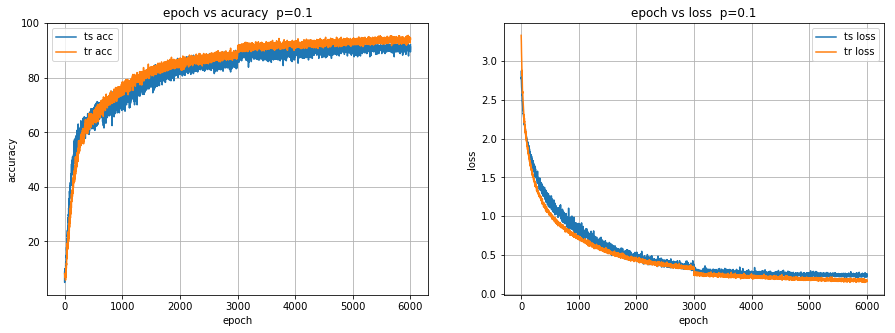

In [49]:
train = 0
test  = 1
acc   = 0
loss  = 1

epochs = len(s1)
x1 = np.linspace(0,epochs,epochs)
x = np.linspace(0,epoch,epoch+1)
for i in range(len(drop_prob_list)):
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
#     ts_a = test_file[i,:,test,acc]
#     ts_l = test_file[i,:,test,loss]
#     tr_a = test_file[i,:,train,acc]
#     tr_l = test_file[i,:,train,loss]
    ts_a = s1[:,test,acc]
    ts_l = s1[:,test,loss]
    tr_a = s1[:,train,acc]
    tr_l = s1[:,train,loss]
    
    plt.plot(x1,ts_a,label='ts acc')
    plt.plot(x1,tr_a,label='tr acc')
    plt.title('epoch vs acuracy  p=' + str(drop_prob_list[i]))
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend()
    plt.grid()
    
    plt.subplot(1,2,2)
    plt.plot(x1,ts_l,label='ts loss')
    plt.plot(x1,tr_l,label='tr loss')
    plt.title('epoch vs loss  p=' + str(drop_prob_list[i]))
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    plt.grid()
    